# Apple Product Launch Backtesting

This notebook analyzes how Apple stock (AAPL) reacts to product launches using CAPM-adjusted abnormal returns and backtesting. It includes event studies, strategy optimization by Sharpe ratio, Monte Carlo simulations, and risk metrics.

In [1]:
import numpy as np
from scipy.stats import ttest_1samp

from scripts.data_loader       import load_data
from scripts.event_study       import event_study
from scripts.strategy_backtest import (
    build_offset_grid,
    run_backtest,
    summarize_backtest,
    backtest_per_product_type
)
from scripts.monte_carlo       import (
    bootstrap_abnormal_returns,
    simulate_strategy,
    confidence_interval,
    block_bootstrap,
    probability_of_success
)
from scripts.risk_metrics      import calculate_risk_metrics_summary
from scripts.viz                import plot_sharpe_heatmap


In [2]:
# 1) Load & prepare data
aapl_prices, sp500_prices, launches = load_data()
aapl_prices, sp500_prices, launches = event_study(aapl_prices, sp500_prices, launches)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# 2) Top 5 Launches by CAR
print("=== Top 5 Product Launches by CAR for Each Product Type ===")
for ptype, group in launches.groupby("Product Type"):
    top5 = group.sort_values("CAR", ascending=False).head(5)
    print(f"\n▶ {ptype} (top 5 by CAR):")
    for _, row in top5.iterrows():
        print(f"  {row['Release Date'].date()} | {row['Family']} | CAR: {row['CAR']:.4f}")


=== Top 5 Product Launches by CAR for Each Product Type ===

▶ AirPods (top 5 by CAR):
  2022-09-23 | Headphones | CAR: 0.0481
  2019-03-20 | Headphones | CAR: 0.0259
  2020-12-15 | Headphones | CAR: 0.0162
  2016-12-19 | Headphones | CAR: 0.0142
  2019-10-30 | Headphones | CAR: 0.0140

▶ Mac (top 5 by CAR):
  1993-10-18 | Macintosh LC | CAR: 0.2501
  1999-08-31 | Macintosh Server | CAR: 0.1867
  1999-10-13 | Power Macintosh | CAR: 0.1490
  2008-10-14 | MacBook Air | CAR: 0.1363
  1990-03-19 | Mac II | CAR: 0.1211

▶ iPad (top 5 by CAR):
  2012-03-16 | iPad | CAR: 0.0670
  2015-09-09 | iPad | CAR: 0.0432
  2019-03-18 | iPad | CAR: 0.0418
  2014-10-22 | iPad | CAR: 0.0378
  2017-03-24 | iPad | CAR: 0.0341

▶ iPhone (top 5 by CAR):
  2016-09-16 | iPhone | CAR: 0.0788
  2017-11-03 | iPhone | CAR: 0.0659
  2008-07-11 | iPhone | CAR: 0.0410
  2013-09-20 | iPhone | CAR: 0.0361
  2011-10-14 | iPhone | CAR: 0.0327

▶ iPod (top 5 by CAR):
  2003-05-02 | iPod Classic | CAR: 0.2353
  2004-01-08 |

In [4]:
# 3) Backtest by product type
buy_offsets = list(range(6))
sell_offsets = list(range(1, 11))
leaderboard = backtest_per_product_type(aapl_prices, launches, buy_offsets, sell_offsets)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


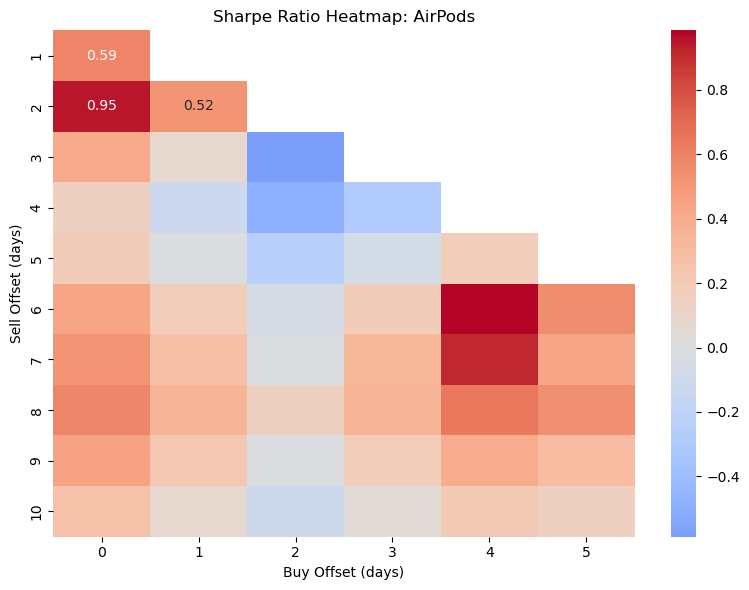

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


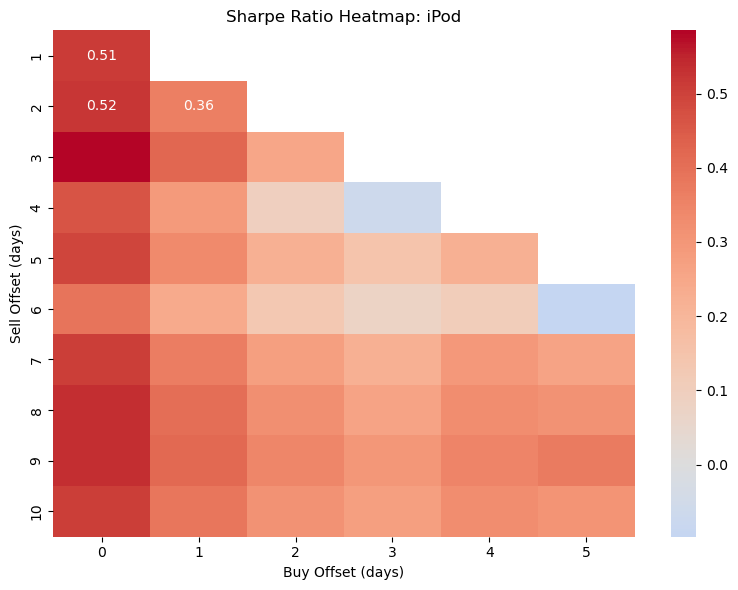

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


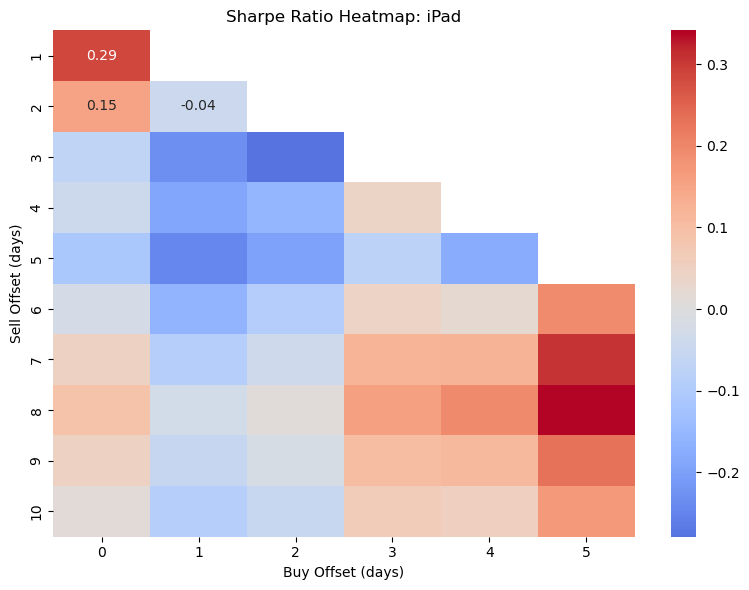

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


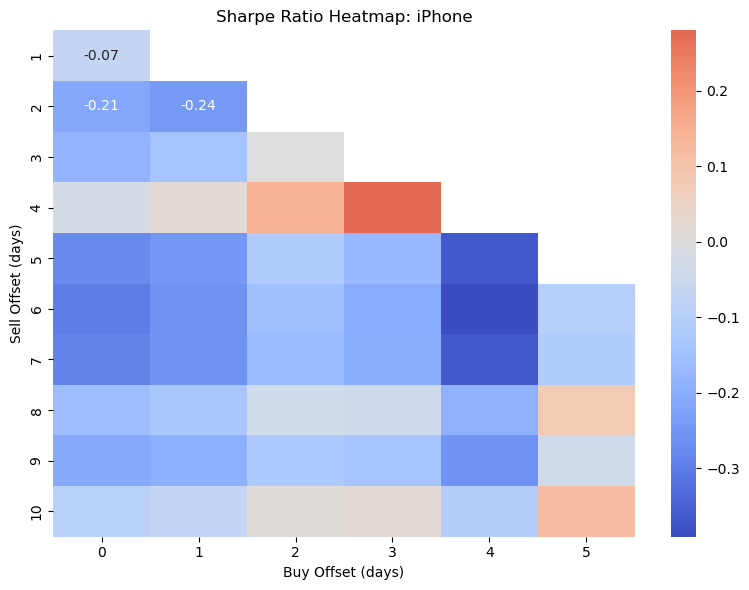

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


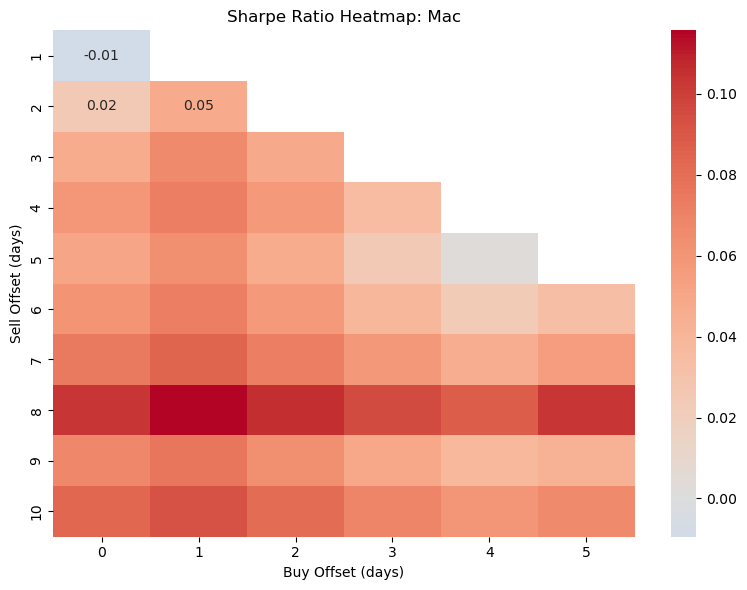

In [5]:
# 4) Sharpe ratio heatmaps
for p in leaderboard['product_type'].unique():
    plot_sharpe_heatmap(leaderboard, p)


In [6]:
# 5) Best Sharpe ratios
print("=== Best Sharpe ratios by product family ===")
print(leaderboard.head(15).to_string(index=False))

best_per_type = (
    leaderboard
    .sort_values(["product_type", "sharpe"], ascending=[True, False])
    .groupby("product_type")
    .head(1)
)
print("\n=== Top rule for each product family ===")
print(best_per_type[["product_type", "buy", "sell", "sharpe", "hit_rate", "n_events"]].to_string(index=False))


=== Best Sharpe ratios by product family ===
 buy  sell     mean      std   sharpe  hit_rate product_type  n_events  rank_within_type
   4     6 0.010243 0.010405 0.984388  0.750000      AirPods         8               1.0
   0     2 0.017007 0.017874 0.951497  0.875000      AirPods         8               2.0
   4     7 0.011639 0.012758 0.912274  0.750000      AirPods         8               3.0
   4     8 0.016506 0.025649 0.643505  0.625000      AirPods         8               4.0
   0     1 0.009097 0.015461 0.588372  0.625000      AirPods         8               5.0
   0     3 0.029230 0.049947 0.585221  0.727273         iPod        22               1.0
   0     8 0.021534 0.037575 0.573097  0.625000      AirPods         8               6.0
   5     6 0.007526 0.013820 0.544563  0.625000      AirPods         8               7.0
   5     8 0.013737 0.025590 0.536806  0.625000      AirPods         8               8.0
   0     8 0.046364 0.086377 0.536762  0.636364         iPod     

In [7]:
# 6) Monte Carlo & Risk Metrics for best rules
print("\n=== Monte Carlo & Risk‐Metrics per product family ===")
for _, row in best_per_type.iterrows():
    ptype = row["product_type"]
    buy   = int(row["buy"])
    sell  = int(row["sell"])

    ar = aapl_prices["Abnormal Return"].dropna()
    sims = bootstrap_abnormal_returns(ar)
    mc   = simulate_strategy(sims, buy, sell)

    sharpe_vals = np.array(mc["sharpe"])
    mean_vals   = np.array(mc["mean"])

    sharpe_ci = confidence_interval(sharpe_vals, 0.05, 0.95)
    prob_pos  = probability_of_success(mean_vals, 0)

    dates     = launches[launches["Product Type"] == ptype]["Release Date"].tolist()
    real_map  = run_backtest(aapl_prices, dates, [(buy, sell)])
    real_rets = real_map[(buy, sell)]
    risk_sum  = calculate_risk_metrics_summary(real_rets)

    print(f"\n→ {ptype}: buy @+{buy}, sell @+{sell}")
    print(f"   • MC Sharpe 90% CI : [{sharpe_ci[0]:.2f}, {sharpe_ci[1]:.2f}]")
    print(f"   • P(mean>0)        : {prob_pos:.1%}")
    print("   • Real risk summary:")
    for metric, value in risk_sum.items():
        print(f"       – {metric:15s}: {value:.4f}")



=== Monte Carlo & Risk‐Metrics per product family ===

→ AirPods: buy @+4, sell @+6
   • MC Sharpe 90% CI : [-0.03, 0.00]
   • P(mean>0)        : 12.7%
   • Real risk summary:
       – VaR(5%)        : -0.0030
       – CVaR(5%)       : -0.0046
       – max_drawdown   : -0.0002
       – duration       : 6.0000
       – downside_deviation: 0.0031
       – worst_loss     : -0.0046
       – loss_rate      : 0.2500
       – Sortino        : 3.3201

→ Mac: buy @+1, sell @+8
   • MC Sharpe 90% CI : [-0.03, 0.00]
   • P(mean>0)        : 12.5%
   • Real risk summary:
       – VaR(5%)        : -0.0957
       – CVaR(5%)       : -0.1235
       – max_drawdown   : -0.3737
       – duration       : 99.0000
       – downside_deviation: 0.0418
       – worst_loss     : -0.1856
       – loss_rate      : 0.4554
       – Sortino        : 0.1791

→ iPad: buy @+5, sell @+8
   • MC Sharpe 90% CI : [-0.03, 0.01]
   • P(mean>0)        : 12.9%
   • Real risk summary:
       – VaR(5%)        : -0.0302
       – 

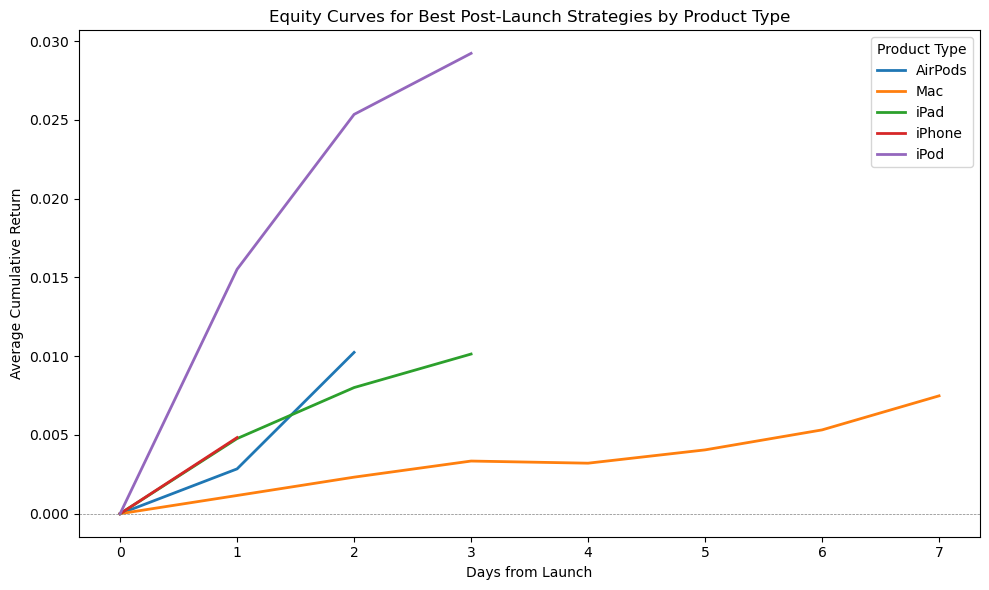

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Compute per-strategy equity curves (averaged across launches)
equity_curves = {}
for _, row in best_per_type.iterrows():
    ptype = row["product_type"]
    buy, sell = int(row["buy"]), int(row["sell"])
    curves = []
    for date in launches[launches["Product Type"] == ptype]["Release Date"]:
        # find launch index
        idx = aapl_prices.index.get_indexer([date], method="bfill")[0]
        # slice from buy day through sell day
        window = aapl_prices['Close'].iloc[idx + buy : idx + sell + 1]
        # compute simple returns and cumulative return series
        ret = window.pct_change().fillna(0)
        cum = (1 + ret).cumprod() - 1
        # re-index so 0 = launch day
        cum.index = range(len(cum))
        curves.append(cum)
    # average across all launch events
    equity_curves[ptype] = pd.concat(curves, axis=1).mean(axis=1)

# 2) Plot them together
plt.figure(figsize=(10, 6))
for ptype, series in equity_curves.items():
    plt.plot(series.index, series.values, label=ptype, linewidth=2)
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.xlabel("Days from Launch")
plt.ylabel("Average Cumulative Return")
plt.title("Equity Curves for Best Post-Launch Strategies by Product Type")
plt.legend(title="Product Type")
plt.tight_layout()
plt.show()
